Embryo classification based on microscopic images  

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 7.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


<a id="1"></a>
# **<center><span style="color:#005dc4;">Import Libraries</span></center>**

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as t
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import gc
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Matplotlib is building the font cache; this may take a moment.


In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [5]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Data preparation
ROOT_PATH = "hvwc23-20240525T143849Z-001/hvwc23/"
train_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
train_df['path'] = ROOT_PATH + 'train/' + train_df['Image']

In [7]:
print(train_df.shape)

(840, 3)


[716 124]


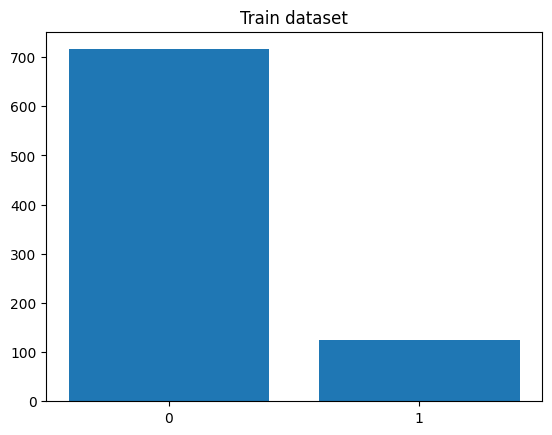

In [8]:
# all data visualization
labels = train_df['Class'].value_counts()
plt.bar(['0','1'], labels.values)
print(labels.values)
plt.title('Train dataset')
plt.show()

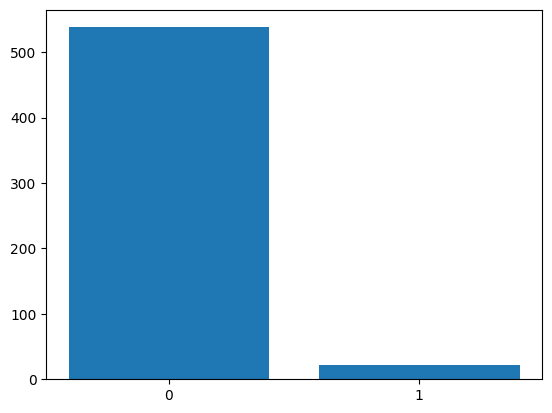

[538  22]


In [9]:

# contain D3 images
D3 = train_df['Image'].apply(lambda x: 'D3_' in x)
labels = train_df[D3]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)

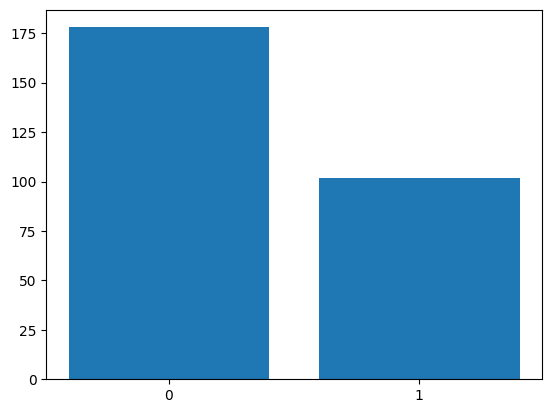

[178 102]


In [10]:


# contain D5 images
D5 = train_df['Image'].apply(lambda x: 'D5_' in x)
labels = train_df[D5]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)


In [11]:
!pip install streamlit
!pip install pyngrok


  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 6.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 6.7 MB/s eta 0:00:00a 0:00:01
Using cached cachetools-5.3.3-py3-none-any.whl (9.3 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 6.4 MB/s eta 0:00:000

In [12]:
!pip install pandas matplotlib

In [13]:
'''
%%writefile app.py
import streamlit as st
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import torch.nn as nn

# Define the CNN model class as used previously
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)

    def forward(self, x):
        return self.base_model(x)

# Load the saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_trained_model.pth'))

# Define preprocessing for uploaded images
def preprocess_jpeg(jpeg_path):
    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return transforms.ToTensor()(img).unsqueeze(0).to(device)

# Prediction function
def predict_image(image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Streamlit interface
st.title('Embryo Image Classification Dashboard')
uploaded_file = st.file_uploader("Choose an embryo image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image_path = f"temp_image.{uploaded_file.type.split('/')[1]}"
    with open(image_path, "wb") as f:
        f.write(uploaded_file.getbuffer())
    st.image(image_path, caption='Uploaded Image.', use_column_width=True)
    image_tensor = preprocess_jpeg(image_path)
    if st.button('Predict'):
        prediction = predict_image(image_tensor)
        st.write("Prediction: **{}**".format("Good Embryo" if prediction == 1 else "Bad Embryo"))
'''

'\n%%writefile app.py\nimport streamlit as st\nimport torch\nfrom torchvision import models, transforms\nimport cv2\nimport numpy as np\nimport torch.nn as nn\n\n# Define the CNN model class as used previously\nclass CNNModel(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.base_model = models.resnet18(pretrained=True)\n        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)\n\n    def forward(self, x):\n        return self.base_model(x)\n\n# Load the saved models\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = CNNModel().to(device)\nmodel.load_state_dict(torch.load(\'best_trained_model.pth\'))\n\n# Define preprocessing for uploaded images\ndef preprocess_jpeg(jpeg_path):\n    img = cv2.imread(jpeg_path)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    img = cv2.resize(img, (224, 224))\n    return transforms.ToTensor()(img).unsqueeze(0).to(device)\n\n# Prediction function\ndef predict_image(image_tensor

In [18]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import KFold, train_test_split
import os

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
ROOT_PATH = "hvwc23-20240525T143849Z-001/hvwc23/"
data_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
data_df['path'] = ROOT_PATH + 'train/' + data_df['Image']

# Assuming `data_df` is already defined with the necessary data
# Splitting data into training and testing
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Define the CNN model class
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)

    def forward(self, x):
        return self.base_model(x)

# Function to preprocess images
def preprocess_jpeg(jpeg_path):
    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return transforms.ToTensor()(img)

# Custom Dataset class
class EmbryoData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['path']
        image = preprocess_jpeg(img_path)
        label = self.dataframe.iloc[index]['Class']
        return image, label, self.dataframe.iloc[index]['Image']

# Training function with K-Fold Cross-Validation
def train_kfold(num_epochs=3, num_folds=5):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    best_accuracy = 0
    best_model_state = None
    metrics = {'epoch': [], 'fold': [], 'accuracy': [], 'loss': []}

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_df)):
        print(f'FOLD {fold}')
        train_sub = train_df.iloc[train_ids]
        val_sub = train_df.iloc[val_ids]

        train_dataset = EmbryoData(train_sub)
        val_dataset = EmbryoData(val_sub)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels, _ in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validate after every epoch
            model.eval()
            correct = 0
            total = 0
            val_loss = 0.0
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += criterion(outputs, labels).item()

            accuracy = 100 * correct / total
            avg_loss = val_loss / len(val_loader)
            metrics['epoch'].append(epoch + 1)
            metrics['fold'].append(fold + 1)
            metrics['accuracy'].append(accuracy)
            metrics['loss'].append(avg_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Fold [{fold+1}/{num_folds}], Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}')

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()
                print(f'New best model found at Fold {fold} with accuracy {accuracy}%')

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv('training_metrics.csv', index=False)
    print(f'Best Validation Accuracy: {best_accuracy}%')
    return best_model_state

# Define a function to make predictions with the best model and save the results
def predict_and_save_results(model_state_path, dataframe, output_csv_path):
    if not os.path.exists(model_state_path):
        print("Model state file not found.")
        return

    model = CNNModel().to(device)
    model.load_state_dict(torch.load(model_state_path))
    model.eval()

    dataset = EmbryoData(dataframe)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    image_ids = []
    predictions = []
    with torch.no_grad():
        for images, labels, ids in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            image_ids.extend(ids)
            predictions.extend(predicted.cpu().numpy())

    results_df = pd.DataFrame({
        'Image': image_ids,
        'Predicted_Class': predictions
    })
    results_df.to_csv(output_csv_path, index=False)
    print(f"Predicted results saved to '{output_csv_path}'.")

# Run the training and get the best model state
best_model_state = train_kfold(3, 5)
torch.save(best_model_state, 'best_trained_model.pth')
print("Best model saved as 'best_trained_model.pth'.")

# Run the final prediction on the test dataset and save the results
best_model_path = 'best_trained_model.pth'
results_csv_path = 'test_prediction_results.csv'
predict_and_save_results(best_model_path, test_df, results_csv_path)


FOLD 0


/Users/nipundimanthahevavitharanage/Documents/DIT/CV/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nipundimanthahevavitharanage/Documents/DIT/CV/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Fold [1/5], Accuracy: 83.70%, Loss: 0.3347
New best model found at Fold 0 with accuracy 83.70370370370371%
Epoch [2/3], Fold [1/5], Accuracy: 87.41%, Loss: 0.2724
New best model found at Fold 0 with accuracy 87.4074074074074%
Epoch [3/3], Fold [1/5], Accuracy: 88.15%, Loss: 0.2897
New best model found at Fold 0 with accuracy 88.14814814814815%
FOLD 1
Epoch [1/3], Fold [2/5], Accuracy: 85.93%, Loss: 0.3670
Epoch [2/3], Fold [2/5], Accuracy: 87.41%, Loss: 0.5081
Epoch [3/3], Fold [2/5], Accuracy: 85.93%, Loss: 0.3470
FOLD 2
Epoch [1/3], Fold [3/5], Accuracy: 89.55%, Loss: 0.2694
New best model found at Fold 2 with accuracy 89.55223880597015%
Epoch [2/3], Fold [3/5], Accuracy: 89.55%, Loss: 0.2601
Epoch [3/3], Fold [3/5], Accuracy: 90.30%, Loss: 0.2731
New best model found at Fold 2 with accuracy 90.29850746268657%
FOLD 3
Epoch [1/3], Fold [4/5], Accuracy: 87.31%, Loss: 0.3036
Epoch [2/3], Fold [4/5], Accuracy: 88.06%, Loss: 0.3108
Epoch [3/3], Fold [4/5], Accuracy: 87.31%, L

In [19]:
%%writefile app.py
import streamlit as st
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Define the CNN model class as used previously
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)

    def forward(self, x):
        return self.base_model(x)

# Load the saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
model.load_state_dict(torch.load('best_trained_model.pth'))

# Define preprocessing for uploaded images
def preprocess_jpeg(jpeg_path):
    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return transforms.ToTensor()(img).unsqueeze(0).to(device)

# Prediction function
def predict_image(image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Streamlit interface
st.title('Embryo Image Classification Dashboard')

# Create two columns
col1, col2 = st.columns(2)

with col1:
    uploaded_file = st.file_uploader("Choose an embryo image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        image_path = f"temp_image.{uploaded_file.type.split('/')[1]}"
        with open(image_path, "wb") as f:
            f.write(uploaded_file.getbuffer())
        st.image(image_path, caption='Uploaded Image.', use_column_width=True)
        image_tensor = preprocess_jpeg(image_path)
        if st.button('Predict'):
            prediction = predict_image(image_tensor)
            if prediction == 1:
                st.write("Prediction: **Good Embryo**")
                st.metric(label="Embryo Quality", value="Good Embryo")
            else:
                st.write("Prediction: **Bad Embryo**")
                st.metric(label="Embryo Quality", value="Bad Embryo")

with col2:
    # Load accuracy metrics from CSV
    metrics_df = pd.read_csv('training_metrics.csv')

    # Plot accuracy graph
    fig, ax = plt.subplots()
    for fold in metrics_df['fold'].unique():
        fold_data = metrics_df[metrics_df['fold'] == fold]
        ax.plot(fold_data['epoch'], fold_data['accuracy'], label=f'Fold {fold}')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training Accuracy per Epoch')
    ax.legend()

    st.pyplot(fig)


Writing app.py


In [25]:
!pip install streamlit torch torchvision opencv-python-headless numpy pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 6.0 MB/s eta 0:00:0000:0100:01
